In [1]:
from transformers import ESMForMaskedLM, ESMTokenizer, pipeline
#https://discuss.huggingface.co/t/solved-model-esm-1b-is-not-defined/17104
import pandas as pd
import numpy as np
import uniprot
from Bio.SeqUtils.ProtParam import ProteinAnalysis
import matplotlib.pyplot as plt
import torch
import math
import utilities
import pickle

/Users/daniel/miniconda3/envs/nlp/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
model, alphabet = torch.hub.load("facebookresearch/esm:main", "esm1b_t33_650M_UR50S")

Using cache found in /Users/daniel/.cache/torch/hub/facebookresearch_esm_main


In [2]:
seqids, fastas = uniprot.read_fasta('/Users/daniel/desktop/cp341/uniprot_sprot.fasta')

In [5]:
human_seqids = []
for seqid in seqids:
    temp = [x for x, j in enumerate(fastas[seqid]['description'].split()) if j[0:3] == "OS="][0]
    #print(temp)
    try:
        #print()
        #print(temp)
        first_part = fastas[seqid]['description'].split()[temp]
        if fastas[seqid]['description'].split()[temp+1][0:3] != "OX=":
            first_part += " " + fastas[seqid]['description'].split()[temp+1]
        
        if first_part == "OS=Bacillus subtilis":
            human_seqids.append(seqid)
    except IndexError:
        print(fastas[seqid])
        print(temp)
        break
np.random.seed(8)
chosen = np.random.choice(range(len(human_seqids)), size=1000, replace=False)

In [6]:
len(human_seqids)

4278

In [9]:
len(fastas[human_seqids[chosen[3]]]["sequence"])

926

In [25]:
# mask amino acid, take BCE loss of softmax(predicted) from actual, average for all amino acid of same type, compare across
aa_loss = {}
aa_counts = {}
for i in range(100):
    seq = fastas[seqids[i]]["sequence"]
    if len(seq) > 1000: continue
    seq_list = utilities.mask_seq(seq)
    #for temp_seq in seq_list:
    #get all logit for entire sequence
    results = None
    for x in range(0, len(seq_list), 5):
        temp_result = utilities.forward_pass(model, alphabet, seq_list[x:x+2])
        if results == None:
            results = temp_result
        else:
            results = torch.concat((results, temp_result), dim=0)
        
        break
        #print(results.shape)
        #if i == 10: break
    #print(results)
    # go through, subset to just maxed amino acid, softmax of predicted layer, BCE with real
    for j, result in enumerate(results):
        masked_aa = seq[j]
        correct_row = result[j+1]
        softmax = torch.nn.Softmax(dim=-1)
        soft_row = softmax(correct_row)
        print(soft_row)
        bce = torch.nn.CrossEntropyLoss()
        target = torch.tensor([alphabet.tok_to_idx[masked_aa]])
        print(target)
        loss = bce(torch.reshape(soft_row, (1,33)), target)
        try:
            aa_loss[masked_aa] += float(loss)
        except KeyError:
            aa_loss[masked_aa] = float(loss)
        
        try:
            aa_counts[masked_aa] += 1
        except KeyError:
            aa_counts[masked_aa] = 1
        
    break
    if i % 5 == 0:
        with open('loss.pickle', 'wb') as handle:
            pickle.dump(aa_loss, handle, protocol=pickle.HIGHEST_PROTOCOL) 
        with open('counts.pickle', 'wb') as handle:
            pickle.dump(aa_counts, handle, protocol=pickle.HIGHEST_PROTOCOL) 
        print(i)
    #print(results)



tensor([7.3969e-09, 1.3333e-10, 1.1992e-07, 1.2485e-10, 2.2391e-03, 1.8768e-03,
        1.4526e-03, 1.9771e-03, 2.3802e-03, 2.0557e-03, 1.5114e-03, 1.1638e-03,
        1.1347e-03, 1.5272e-03, 1.5055e-03, 2.0042e-03, 1.0427e-03, 9.3613e-04,
        1.0314e-03, 6.3332e-04, 9.7398e-01, 3.9018e-04, 2.0888e-04, 4.0799e-04,
        5.4353e-04, 5.8820e-07, 8.2129e-08, 3.1243e-07, 3.3904e-10, 4.0626e-10,
        4.3234e-10, 3.6525e-10, 1.2472e-10])
tensor([20])
tensor([4.6671e-09, 4.4372e-10, 1.0131e-07, 3.7111e-10, 2.7749e-02, 1.3188e-01,
        7.3791e-02, 4.9909e-02, 1.8395e-01, 9.9864e-02, 3.1649e-02, 5.2149e-02,
        2.1592e-02, 7.9099e-02, 7.2278e-02, 5.2583e-02, 2.1694e-02, 3.8749e-02,
        1.4386e-02, 1.4874e-02, 8.6578e-03, 1.1750e-02, 5.1326e-03, 8.2459e-03,
        1.8460e-05, 4.0021e-07, 8.2937e-08, 1.7606e-07, 3.0753e-09, 2.4719e-09,
        2.6629e-09, 2.4758e-09, 4.2723e-10])
tensor([5])


In [7]:
with open('human_loss.pickle', 'rb') as handle:
    aa_loss = pickle.load(handle) 
with open('human_counts.pickle', 'rb') as handle:
    aa_counts = pickle.load(handle) 

In [8]:
aa_counts

{'M': 105,
 'P': 301,
 'K': 274,
 'N': 149,
 'A': 327,
 'V': 233,
 'I': 179,
 'L': 382,
 'R': 242,
 'Y': 126,
 'G': 343,
 'S': 428,
 'E': 261,
 'H': 103,
 'T': 210,
 'F': 170,
 'Q': 170,
 'D': 208,
 'W': 74,
 'C': 241,
 'U': 1}

In [14]:
np.array(list(aa_loss.values()))/np.array(list(aa_counts.values()))

array([3.06222761, 3.12006812, 3.07152265, 3.26971068, 3.22343901,
       3.20128833, 3.23369015, 3.10854802, 3.2098239 , 3.06154936,
       3.08768908, 3.198614  , 3.18923776, 3.26732472, 3.27907591,
       3.12462467, 3.23465385, 3.20403579, 3.09398332, 2.90658992,
       3.3269968 ])

In [15]:
aa_loss

{'M': 257.2271189689636,
 'P': 870.4990048408508,
 'K': 731.0223915576935,
 'N': 454.489785194397,
 'A': 967.031702041626,
 'V': 688.2769901752472,
 'I': 507.68935322761536,
 'L': 1000.9524638652802,
 'R': 699.7416095733643,
 'Y': 355.13972544670105,
 'G': 972.6220588684082,
 'S': 1260.2539160251617,
 'E': 711.2000215053558,
 'H': 294.05922508239746,
 'T': 613.1871943473816,
 'F': 471.81832456588745,
 'Q': 501.3713467121124,
 'D': 583.1345131397247,
 'W': 219.67281556129456,
 'C': 645.2629628181458,
 'U': 3.3269968032836914}

In [8]:
results[0].shape

torch.Size([258, 33])

In [26]:
#dict_you_want = { your_key: old_dict[your_key] for your_key in your_keys }
with open('human_loss.pickle', 'rb') as handle:
    human_aa_loss = pickle.load(handle) 
with open('human_counts.pickle', 'rb') as handle:
    human_aa_counts = pickle.load(handle) 
with open('mouse_loss.pickle', 'rb') as handle:
    mouse_aa_loss = pickle.load(handle) 
with open('mouse_counts.pickle', 'rb') as handle:
    mouse_aa_counts = pickle.load(handle) 
with open('bac_loss.pickle', 'rb') as handle:
    bac_aa_loss = pickle.load(handle) 
with open('bac_counts.pickle', 'rb') as handle:
    bac_aa_counts = pickle.load(handle) 
int1 = set(human_aa_counts.keys()).intersection(set(mouse_aa_counts.keys()))
int2 = int1.intersection(set(bac_aa_counts.keys()))
int2 = list(int2)
human_aa_counts = { your_key: human_aa_counts[your_key] for your_key in int2 }
human_aa_loss = { your_key: human_aa_loss[your_key] for your_key in int2 }
mouse_aa_counts = { your_key: mouse_aa_counts[your_key] for your_key in int2 }
mouse_aa_loss = { your_key: mouse_aa_loss[your_key] for your_key in int2 }
bac_aa_counts = { your_key: bac_aa_counts[your_key] for your_key in int2 }
bac_aa_loss = { your_key: bac_aa_loss[your_key] for your_key in int2 }

Text(0, 0.5, 'Average Cross Entropy')

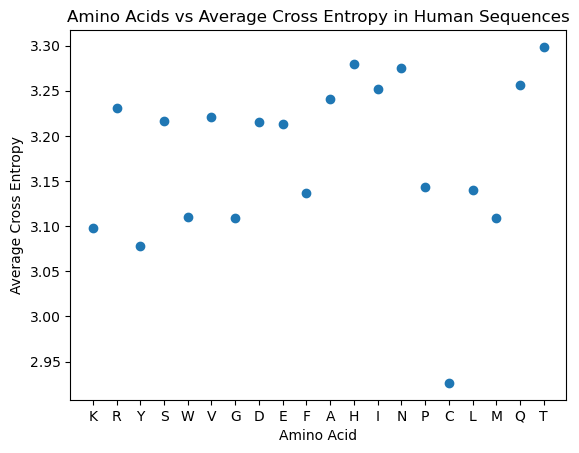

In [27]:

plt.scatter(human_aa_counts.keys(), np.array(list(human_aa_loss.values()))/np.array(list(human_aa_counts.values())))
plt.title("Amino Acids vs Average Cross Entropy in Human Sequences")
plt.xlabel("Amino Acid")
plt.ylabel("Average Cross Entropy")

Text(0, 0.5, 'Average Cross Entropy')

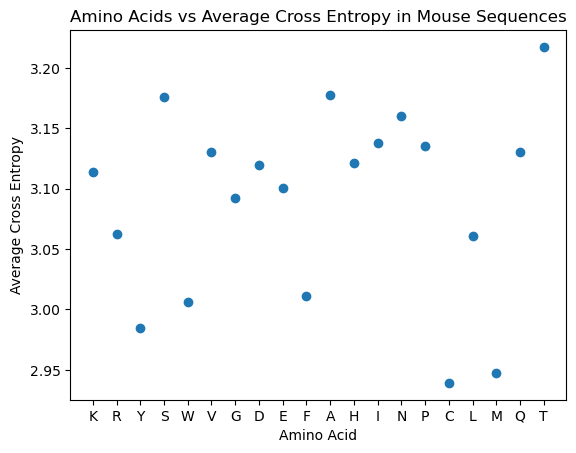

In [28]:

plt.scatter(mouse_aa_counts.keys(), np.array(list(mouse_aa_loss.values()))/np.array(list(mouse_aa_counts.values())))
plt.title("Amino Acids vs Average Cross Entropy in Mouse Sequences")
plt.xlabel("Amino Acid")
plt.ylabel("Average Cross Entropy")

Text(0, 0.5, 'Average Cross Entropy')

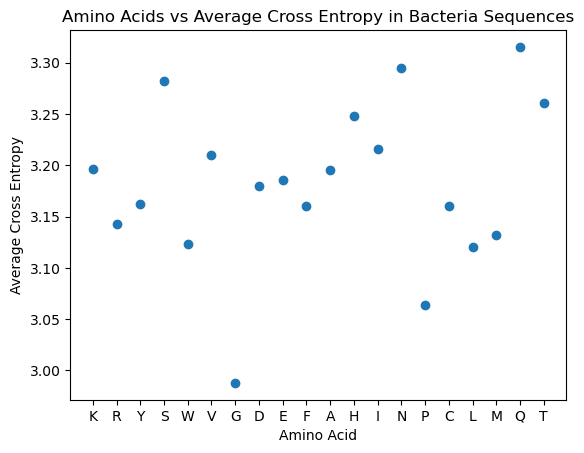

In [29]:

plt.scatter(bac_aa_counts.keys(), np.array(list(bac_aa_loss.values()))/np.array(list(bac_aa_counts.values())))
plt.title("Amino Acids vs Average Cross Entropy in Bacteria Sequences")
plt.xlabel("Amino Acid")
plt.ylabel("Average Cross Entropy")

In [11]:
[("blah", x) for x in seq_list][0]

'<mask>AFSAEDVLKEYDRRRRMEALLLSLYYPNDRKLLDYKEWSPPRVQVECPKAPVEWNNPPSEKGLIVGHFSGIKYKGEKAQASEVDVNKMCCWVSKFKDAMRRYQGIQTCKIPGKVLSDLDAKIKAYNLTVEGVEGFVRYSRVTKQHVAAFLKELRHSKQYENVNLIHYILTDKRVDIQHLEKDLVKDFKALVESAHRMRQGHMINVKYILYQLLKKHGHGPDGPDILTVKTGSKGVLYDDSFRKIYTDLGWKFTPL'

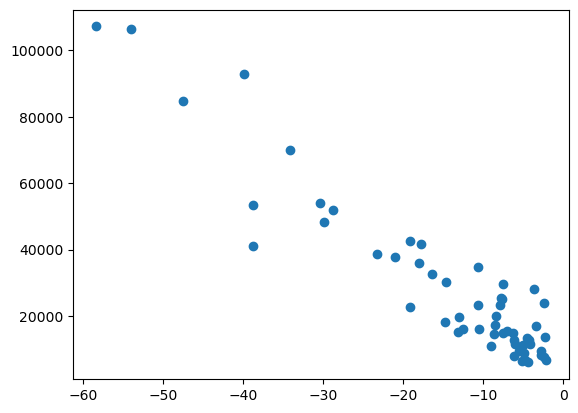

In [41]:
plt.scatter(seq_probs, analysis[0:56,0])

In [30]:
seq_length = np.array(seq_length)

In [66]:
seq_probs = np.array(seq_probs)
seq_probs_norm = seq_probs / np.floor(seq_length/20)[0:56]

TypeError: unsupported operand type(s) for /: 'list' and 'int'

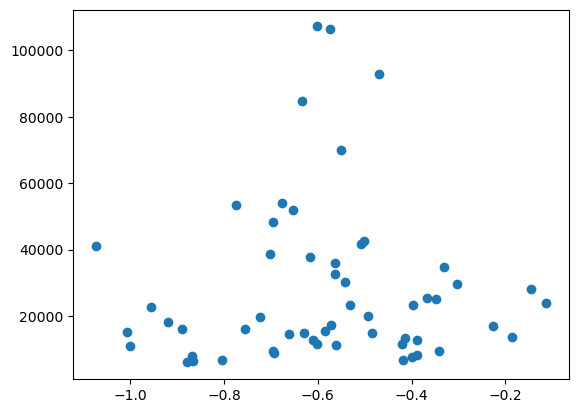

In [43]:
plt.scatter(seq_probs_norm, analysis[0:56,0])

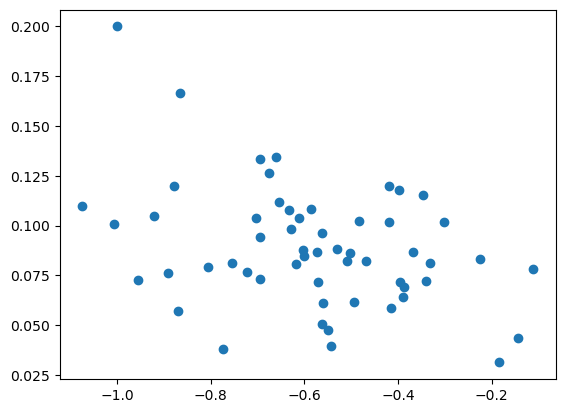

In [49]:
#aromaticity
plt.scatter(seq_probs_norm, analysis[0:56,3])

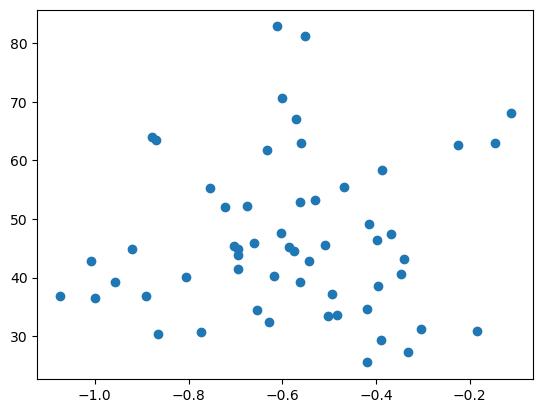

In [53]:
plt.scatter(seq_probs_norm, analysis[0:56,5])